In [7]:
# Cell 1: Imports and setup
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import seaborn as sns
from einops import rearrange

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Loading datasets...
Dataset 1 shape: (10000, 64, 72)
Dataset 2 shape: (10000, 64, 72)


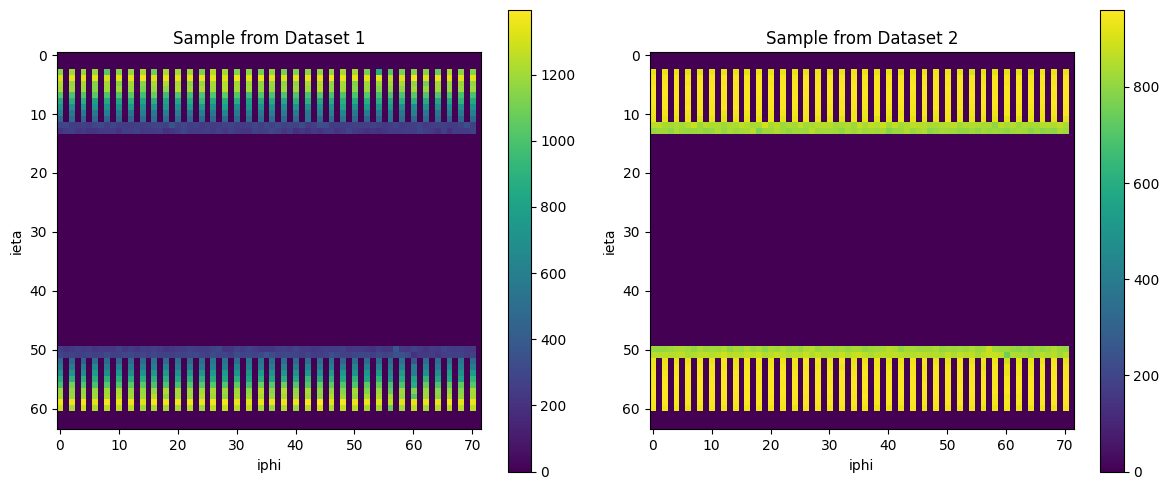

In [8]:
# Cell 2: Load and visualize datasets
# Load datasets
print("Loading datasets...")
dataset1 = np.load('Run355456_Dataset_jqkne.npy')
dataset2 = np.load('Run357479_Dataset_iodic.npy')

print(f"Dataset 1 shape: {dataset1.shape}")
print(f"Dataset 2 shape: {dataset2.shape}")

# Visualize sample images from both datasets
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(dataset1[0], cmap='viridis')
plt.colorbar()
plt.title('Sample from Dataset 1')
plt.xlabel('iphi')
plt.ylabel('ieta')

plt.subplot(1, 2, 2)
plt.imshow(dataset2[0], cmap='viridis')
plt.colorbar()
plt.title('Sample from Dataset 2')
plt.xlabel('iphi')
plt.ylabel('ieta')
plt.tight_layout()
plt.show()

In [9]:
# Cell 3: Dataset class definition
class HCALDataset(Dataset):
    def __init__(self, dataset1, dataset2, transform=None):
        # Create labels: 0 for dataset1, 1 for dataset2
        self.images = np.vstack([dataset1, dataset2])
        self.labels = np.hstack([np.zeros(len(dataset1)), np.ones(len(dataset2))])
        
        # Shuffle the data
        shuffle_idx = np.random.permutation(len(self.images))
        self.images = self.images[shuffle_idx]
        self.labels = self.labels[shuffle_idx]
        
        self.transform = transform
        
        # Perform simple normalization
        self.normalize_data()
        
    def normalize_data(self):
        # Handle potential zero division
        self.images = np.log1p(self.images)  # Log transform to handle skewed distribution
        max_val = np.max(self.images)
        if max_val > 0:
            self.images = self.images / max_val
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx].astype(np.int64)
        
        # Add channel dimension for PyTorch (1 x H x W)
        image = np.expand_dims(image, 0)
        
        return image, label

In [10]:
# Cell 4: Create dataset and data loaders
# Create dataset
dataset = HCALDataset(dataset1, dataset2)

# Split into train, validation and test sets (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Calculate class distribution
all_labels = dataset.labels
class_0_count = np.sum(all_labels == 0)
class_1_count = np.sum(all_labels == 1)

print(f"Class distribution - Class 0: {class_0_count}, Class 1: {class_1_count}")
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Class distribution - Class 0: 10000, Class 1: 10000
Train size: 14000, Validation size: 3000, Test size: 3000
Using device: cpu


In [11]:
# Cell 5: Vision Transformer components
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=8, emb_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )
        
    def forward(self, x):
        x = self.projection(x)  # (batch, emb_dim, n_patches)
        x = x.permute(0, 2, 1)  # (batch, n_patches, emb_dim)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.emb_dim = emb_dim
        self.head_dim = emb_dim // num_heads
        
        self.qkv = nn.Linear(emb_dim, 3 * emb_dim)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_dim, emb_dim)
        
    def forward(self, x):
        batch_size, n_tokens, emb_dim = x.shape
        
        qkv = self.qkv(x)  # (batch, n_tokens, 3*emb_dim)
        qkv = qkv.reshape(batch_size, n_tokens, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch, num_heads, n_tokens, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention score calculation
        k_t = k.transpose(-2, -1)  # (batch, num_heads, head_dim, n_tokens)
        dp = (q @ k_t) * (self.head_dim ** -0.5)  # (batch, num_heads, n_tokens, n_tokens)
        attn = dp.softmax(dim=-1)
        attn = self.att_drop(attn)
        
        weighted = attn @ v  # (batch, num_heads, n_tokens, head_dim)
        weighted = weighted.transpose(1, 2)  # (batch, n_tokens, num_heads, head_dim)
        weighted = weighted.flatten(2)  # (batch, n_tokens, emb_dim)
        
        x = self.projection(weighted)  # (batch, n_tokens, emb_dim)
        return x

class MLP(nn.Module):
    def __init__(self, emb_dim=128, mlp_dim=256, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, emb_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, emb_dim=128, num_heads=4, mlp_dim=256, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_dim)
        self.attn = MultiHeadAttention(emb_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = MLP(emb_dim, mlp_dim, dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [12]:
# Cell 6: Vision Transformer model
class VisionTransformer(nn.Module):
    def __init__(
        self, 
        image_size=(64, 72),
        in_channels=1,
        patch_size=8,
        emb_dim=128,
        num_layers=6,
        num_heads=4,
        mlp_dim=256,
        num_classes=2,
        dropout=0.1
    ):
        super().__init__()
        self.patch_size = patch_size
        
        # Calculate number of patches
        num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size)
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_dim)
        
        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, emb_dim))
        
        # Transformer blocks
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(emb_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)]
        )
        
        # Layer normalization and MLP head
        self.norm = nn.LayerNorm(emb_dim)
        self.mlp_head = nn.Linear(emb_dim, num_classes)
        
        # Initialize weights
        self.initialize_weights()
        
    def initialize_weights(self):
        # Initialize patch embedding
        nn.init.xavier_uniform_(self.patch_embed.projection[0].weight)
        
        # Initialize position embeddings
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Initialize linear layers
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embed(x)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add position embeddings
        x = x + self.pos_embed
        
        # Apply transformer blocks
        x = self.transformer_blocks(x)
        
        # Layer normalization
        x = self.norm(x)
        
        # Use only the class token for classification
        x = x[:, 0]
        
        # MLP head
        x = self.mlp_head(x)
        
        return x

In [13]:
# Cell 7: Model initialization and training setup
# Create the Vision Transformer model
model = VisionTransformer(
    image_size=(64, 72),
    in_channels=1,
    patch_size=8,
    emb_dim=128,
    num_layers=4,
    num_heads=4,
    mlp_dim=256,
    num_classes=2,
    dropout=0.1
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [14]:
# Cell 8: Training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels for ROC curve
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / len(dataloader)
    val_acc = correct / total
    return val_loss, val_acc, all_preds, all_labels

Starting training for 10 epochs...
Epoch 1/10, Train Loss: 0.4793, Train Acc: 0.7251, Val Loss: 0.0086, Val Acc: 0.9987
Epoch 2/10, Train Loss: 0.6619, Train Acc: 0.5860, Val Loss: 0.7304, Val Acc: 0.5027
Epoch 3/10, Train Loss: 0.6503, Train Acc: 0.6325, Val Loss: 0.5878, Val Acc: 0.9253
Epoch 4/10, Train Loss: 0.1512, Train Acc: 0.9539, Val Loss: 0.0110, Val Acc: 0.9990
Epoch 5/10, Train Loss: 0.0166, Train Acc: 0.9971, Val Loss: 0.0061, Val Acc: 0.9990
Epoch 6/10, Train Loss: 0.0240, Train Acc: 0.9949, Val Loss: 0.0080, Val Acc: 0.9987
Epoch 7/10, Train Loss: 0.0132, Train Acc: 0.9979, Val Loss: 0.0046, Val Acc: 0.9993
Epoch 8/10, Train Loss: 0.0121, Train Acc: 0.9980, Val Loss: 0.0046, Val Acc: 0.9990
Epoch 9/10, Train Loss: 0.0101, Train Acc: 0.9984, Val Loss: 0.0039, Val Acc: 0.9997
Epoch 10/10, Train Loss: 0.0078, Train Acc: 0.9989, Val Loss: 0.0039, Val Acc: 0.9997


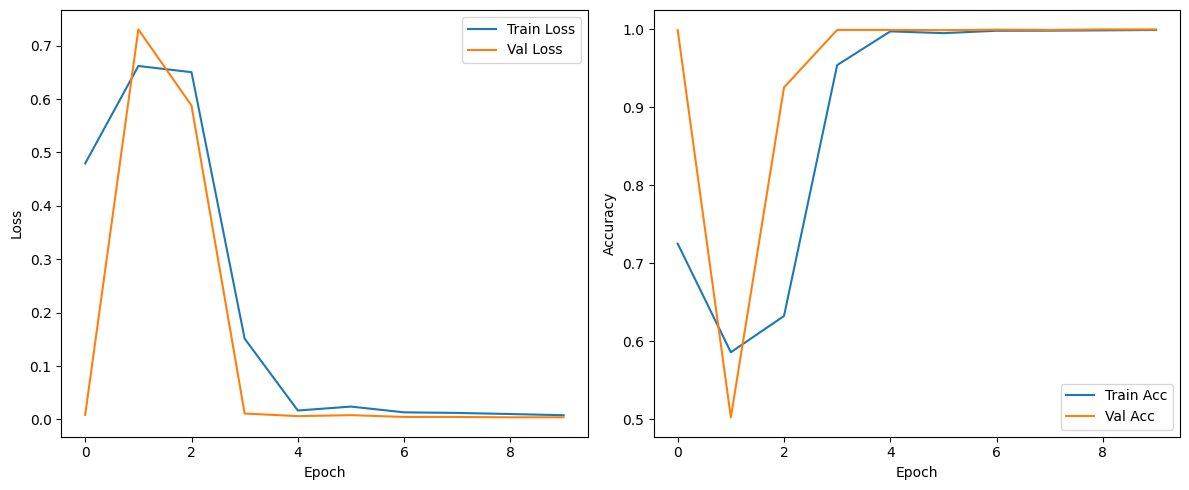

In [15]:
# Cell 9: Training loop
num_epochs = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)
    
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Test Loss: 0.0152, Test Accuracy: 0.9980


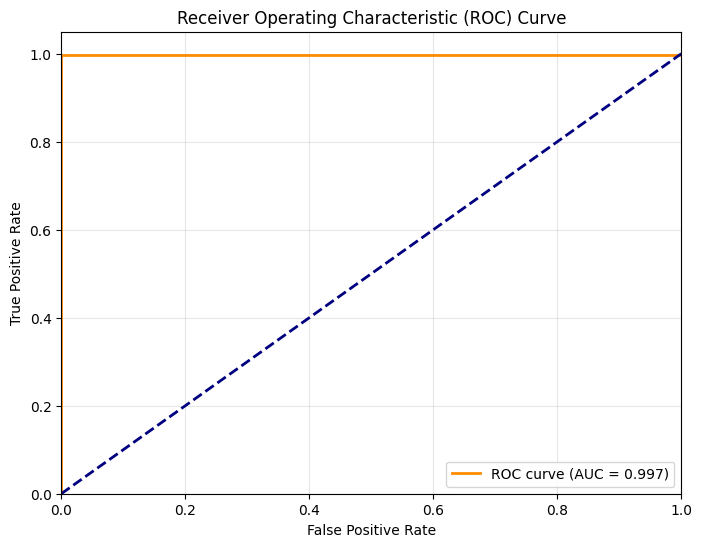

In [16]:
# Cell 10: Test evaluation
# Load best model for evaluation
model.load_state_dict(torch.load('best_vit_model.pth'))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

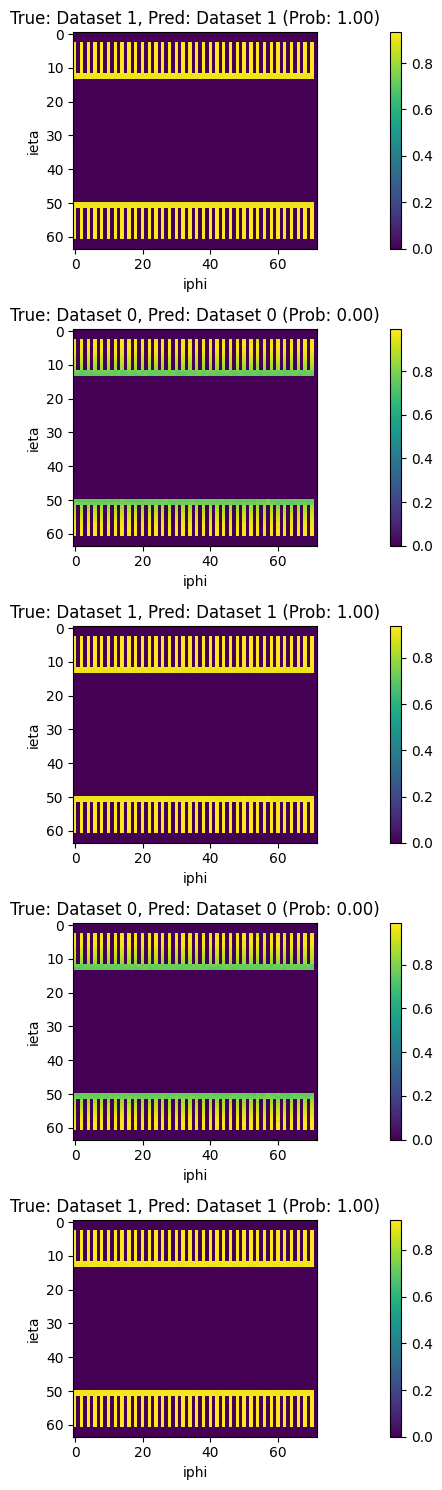

In [17]:
# Cell 11: Prediction visualization
def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
    
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(images[i][0].cpu().numpy(), cmap='viridis')
        plt.title(f"True: Dataset {labels[i].item()}, Pred: Dataset {preds[i].item()} (Prob: {probs[i]:.2f})")
        plt.colorbar()
        plt.xlabel('iphi')
        plt.ylabel('ieta')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, device)

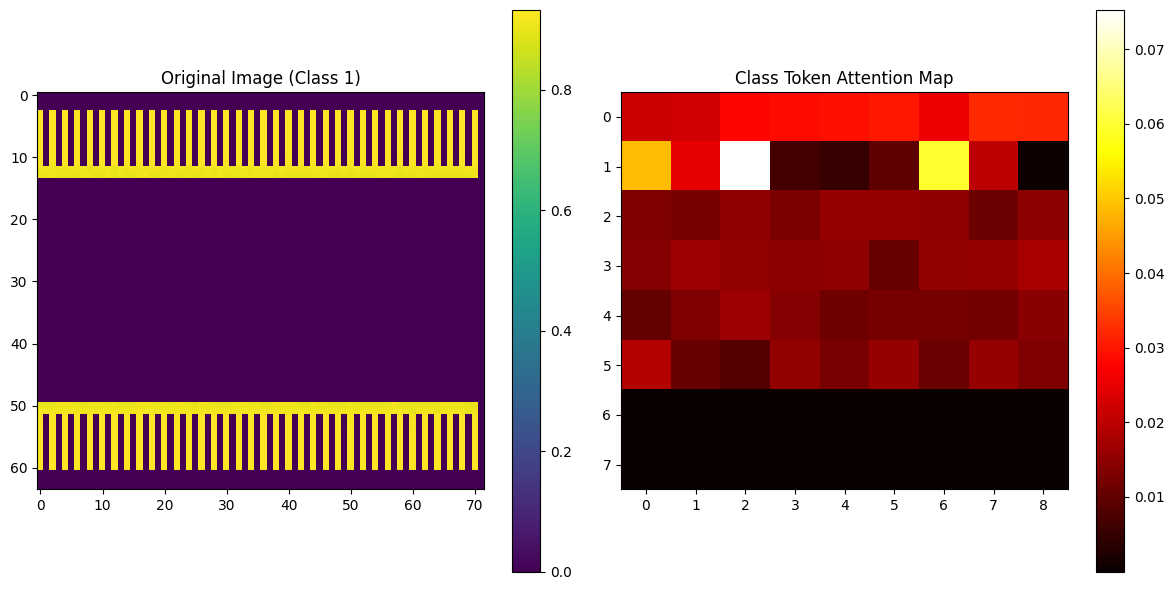

In [18]:
# Fix the visualize_attention function
def visualize_attention(model, dataloader, device):
    # Get a batch of data
    images, labels = next(iter(dataloader))
    image = images[0:1].to(device)  # Get single image
    
    # Forward pass up to the attention
    model.eval()
    
    # Get number of heads from the first transformer block's attention
    num_heads = model.transformer_blocks[0].attn.num_heads
    
    # Patch embedding
    patches = model.patch_embed(image)
    batch_size = patches.shape[0]
    
    # Add class token
    cls_tokens = model.cls_token.expand(batch_size, -1, -1)
    x = torch.cat((cls_tokens, patches), dim=1)
    
    # Add position embeddings
    x = x + model.pos_embed
    
    # First transformer block to extract attention
    with torch.no_grad():
        # Create hook to get attention maps
        attention_maps = []
        def hook_fn(module, input, output):
            # Extract attention weights
            qkv = module.qkv(input[0])
            batch_size, n_tokens, _ = qkv.shape
            qkv = qkv.reshape(batch_size, n_tokens, 3, module.num_heads, module.head_dim)
            qkv = qkv.permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]
            
            # Calculate attention scores
            k_t = k.transpose(-2, -1)
            dp = (q @ k_t) * (module.head_dim ** -0.5)
            attn = dp.softmax(dim=-1)
            attention_maps.append(attn.detach().cpu())
        
        # Register hook on the attention module of the first transformer block
        hook = model.transformer_blocks[0].attn.register_forward_hook(hook_fn)
        
        # Forward pass
        _ = model(image)
        
        # Remove hook
        hook.remove()
    
   
    attention = attention_maps[0][0]  # batch 0
    cls_attention = attention[:, 0, 1:].reshape(num_heads, -1)
    
    # Get grid dimensions
    h = 64 // model.patch_size
    w = 72 // model.patch_size
    
    # Reshape to spatial grid
    attention_map = cls_attention.mean(0).reshape(h, w)
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image[0, 0].cpu().numpy(), cmap='viridis')
    plt.title(f"Original Image (Class {labels[0].item()})")
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(attention_map, cmap='hot')
    plt.title("Class Token Attention Map")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()


visualize_attention(model, test_loader, device)
    
  

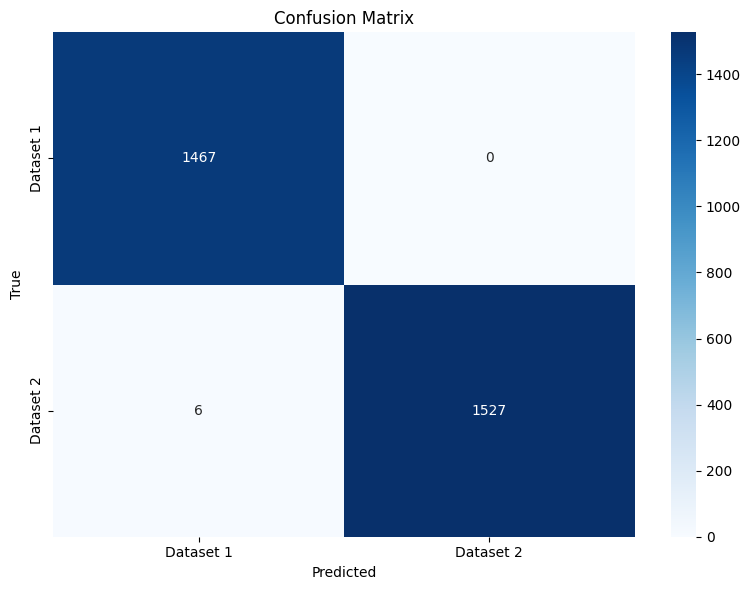

In [19]:
# Cell 13: Confusion matrix
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for i in range(len(y_true)):
        conf_matrix[y_true[i], y_pred[i]] += 1
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Dataset 1', 'Dataset 2'],
                yticklabels=['Dataset 1', 'Dataset 2'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, test_loader, device)

In [20]:
# Cell 14: Final metrics
# Print final evaluation metrics
print("\nFinal Evaluation Metrics:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"AUC: {roc_auc:.4f}")


Final Evaluation Metrics:
Test Accuracy: 0.9980
AUC: 0.9974
